# Applying a GCN to the elliptic Bitcoin blockchain transaction dataset

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn 


In [25]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [2]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [3]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)



---



## Data preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd drive/MyDrive/GCN_elliptic_project/

/content/drive/MyDrive/GCN_elliptic_project


In [8]:
!unzip Elliptic_kaggle_Dataset.zip  -d /content

Archive:  Elliptic_kaggle_Dataset.zip
replace /content/elliptic_bitcoin_dataset/elliptic_txs_classes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
cd /content/elliptic_bitcoin_dataset/

/content/elliptic_bitcoin_dataset


In [7]:
edges = pd.read_csv("elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_txs_classes.csv")

In [18]:
print(edges.shape)
print(features.shape)

(36624, 2)
(46564, 168)


Name all the features, differentiate features (only node, multiple nodes) and go for 0 class instead of unknown 

In [8]:
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features

#merge features and classes
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

Remove all the unknown part of the network, for now


In [9]:
features= features[features['class'] != '0' ]


In [12]:
def check(name):
  if(name in unique):
    return name 
  else : 
    return -1 

In [13]:
unique = features['txId'].unique()
edges["txId1"] = edges["txId1"].apply(lambda name: check(name))
edges["txId2"] = edges["txId2"].apply(lambda name: check(name))

In [14]:
edges = edges[edges["txId1"] != -1 ]
edges = edges[edges["txId2"] != -1 ]

In [17]:
print(edges.shape)
print(features.shape)

(36624, 2)
(46564, 168)


Change the txID in both features and edges to a simple index. This makes the computation of the adjency matrix easier

In [19]:
class_values = sorted(features["class"].unique())
features_idx = {name: idx for idx, name in enumerate(sorted(features["txId"].unique()))}

features["txId"] = features["txId"].apply(lambda name: features_idx[name])
edges["txId1"] = edges["txId1"].apply(lambda name: features_idx[name])
edges["txId2"] = edges["txId2"].apply(lambda name: features_idx[name])

In [20]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges2 = edges[["txId1", "txId2"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges2.shape[1])
# Create a node features array of shape [num_nodes, num_features].
# IN the next line we select the features to include in the graph 
# Notice than only tx_features are present!

node_features = tf.cast(
    features.sort_values("txId")[tx_features].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges2, edge_weights)

print("Edges shape:", edges2.shape)
print("Nodes shape:", node_features.shape)
print("edge weights shape:", edge_weights.shape)

Edges shape: (2, 36624)
Nodes shape: (46564, 93)
edge weights shape: (36624,)


In [61]:
# Define the parameters for the network 

num_classes = len(class_values)
print("num classes = " , num_classes)

hidden_units = [16, 16]
learning_rate = 0.01
dropout_rate = 0.5
#0.5
num_epochs = 15
batch_size = 256
#256

num classes =  2


### Implementing the convoluted network 

In [34]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [23]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)


In [62]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1,10,100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 4.6425092e-01  3.8040507e+00]
 [-2.9657626e-01  2.8956980e-03]
 [-1.6206534e-01  7.2608851e-02]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (46564, 16)               2212      
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  1664      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  1664      
_________________________________________________________________
postprocess (Sequential)     (46564, 16)               672       
_________________________________________________________________
logits (Dense)               multiple                  34        
Total params: 6,246
Trainable params: 5,644
Non-trainable params: 602
__________________________

### Train the network

In [63]:
from sklearn.model_selection import train_test_split

X = features[tx_features + ['txId'] ]
y = features['class']
y = y.apply(lambda x: 0 if x == '2' else 1 )
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=15,shuffle=False)

In [64]:
# for training I only need txID, everything else is already in the network 
x_train = X_train.txId.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/15
109/109 [==============================] - 51s 439ms/step - loss: 0.3501 - acc: 0.8762 - val_loss: 0.3022 - val_acc: 0.8800
Epoch 2/15
109/109 [==============================] - 47s 432ms/step - loss: 0.2670 - acc: 0.8886 - val_loss: 0.2438 - val_acc: 0.8800
Epoch 3/15
109/109 [==============================] - 47s 434ms/step - loss: 0.2340 - acc: 0.8952 - val_loss: 0.2155 - val_acc: 0.8800
Epoch 4/15
109/109 [==============================] - 47s 434ms/step - loss: 0.2124 - acc: 0.9160 - val_loss: 0.2398 - val_acc: 0.8800
Epoch 5/15
109/109 [==============================] - 47s 435ms/step - loss: 0.1966 - acc: 0.9278 - val_loss: 0.1433 - val_acc: 0.9587
Epoch 6/15
109/109 [==============================] - 48s 437ms/step - loss: 0.1831 - acc: 0.9337 - val_loss: 0.1361 - val_acc: 0.9630
Epoch 7/15
109/109 [==============================] - 48s 438ms/step - loss: 0.1830 - acc: 0.9356 - val_loss: 0.1273 - val_acc: 0.9571
Epoch 8/15
109/109 [==============================] - 4

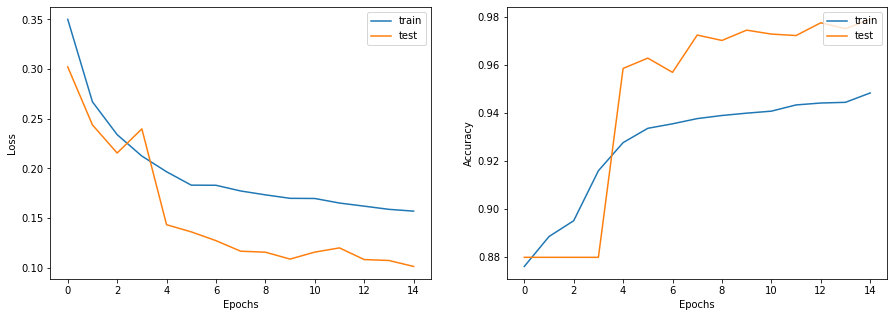

In [65]:
display_learning_curves(history)

### Test the results

In [38]:
x_test = X_test.txId.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 93.71%


In [66]:
preds = gnn_model.predict(x_test)

In [74]:
norm_preds = sklearn.preprocessing.normalize(preds)

y_predicted = []
for pred in norm_preds:
  if pred[0] > pred[1]:
    y_predicted.append(0)
  else :
    y_predicted.append(1)

In [68]:
prec,rec,f1,num = sklearn.metrics.precision_recall_fscore_support(y_test,y_predicted, average=None)
print("Convoluted neural network")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = sklearn.metrics.f1_score(y_test,y_predicted,average='micro')
print("Micro-Average F1 Score:",micro_f1)

A bit better neural network (still shit)
Precision:0.919 
Recall:0.605 
F1 Score:0.730
Micro-Average F1 Score: 0.9717967072297781
